### Predicción de áreas con infraestructura construida a partir de Imágenes Satelitales
#####Autor: Unidad de Ciencia de Datos (UCD)

En este cuaderno se aplica el proceso de predicción de áreas con infraestructura construida presentado en el [informe](https://github.com/ucd-dnp/inudaciones_ucd/blob/master/dataSandbox/1_Metodologia/Informe_metodologico.pdf) que puede encontrar en la sección ["Piloto DataSandbox"](https://github.com/ucd-dnp/inudaciones_ucd/tree/master/dataSandbox) del presente [repositorio](https://github.com/ucd-dnp/inudaciones_ucd). 

Para el adecuado funcionamiento de este ejemplo se deben instalar e importar las siguientes liblerías:

In [0]:
'''Antes de importar los paquetes instale las siguientes librerías:

    urllib3 version 1.25.8
    pyproj version 2.4.2.post1
    GDAL version 3.0.2  
    Pillow version 7.0.0
    numpay version 1.18.1
    matplotlib version 3.1.3
    OpenCV version 4.1.0
    tifffile version 2021.1.11
    Shapely version 1.7.0
    scikit-image version 0.16.2  
    scikit-learn version 0.22.1 
    geopandas version 0.8.1
    rasterio version 1.1.0
    pandas version 1.0.1
    mlflow version 1.11.0
    descartes version 1.1.0

''' 

import urllib                                    
import os                                                                           
import math
import pyproj                                     
from pyproj import Transformer
from osgeo import gdal                            
from PIL import Image                             
import numpy as np                               
import matplotlib.pyplot as plt                   
import cv2                                       

from collections import defaultdict
from contextlib import contextmanager  
import tifffile as tiff                           
from tifffile import imread
from shapely.affinity import affine_transform     
from shapely.geometry import MultiPolygon, Polygon 
from skimage.exposure import equalize_adapthist, equalize_hist              
from skimage.feature import hog                                                   

from skimage.measure import regionprops, label
from skimage.segmentation import quickshift, felzenszwalb,slic
import matplotlib.pyplot as plt                                                     
from multiprocessing.dummy import Pool                                              
import time
import geopandas as gpd                                                           

import rasterio                                                                   
from rasterio import Affine, MemoryFile
import rasterio.mask as mask
import pandas as pd                                                                

import mlflow                                                                      
import mlflow.pyfunc
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from hyperopt.pyll import scope
from numpy import arange

from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

import descartes                                                                    
import warnings

from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK


Las clases `GoogleMapDownloader` e `imtools` permiten la obtención y procesamiento de imágenes satelitales de google maps correspondientes al área de analisis de interés. Estas se definen en los siguientes comandos.

In [0]:
class GoogleMapDownloader:
    """
    Esta clase genera imágenes de google maps de alta resolución a partir de 
    un conjunto de coordenas (latitud longitud) y nivel de enfoque(zoom). 
    """
 
    def __init__(self, coords= None, zoom=17, tile_size = 256, proj=None,
                 PIXEL_SIZE_X = 1.1937, PIXEL_SIZE_Y= 1.1860):
        """
            GoogleMapDownloader Constructor
            Args:
                coords:     coordinate Box, (left, top, right, bottom)
                zoom:       The zoom level of the location required,
                            ranges from 0 - 23.  defaults to 17
                tile_size:  Size for tile of google maps
                proj:       image crs.
                PIXEL_SIZE_X: pixel size on image (meters) x direction
                PIXEL_SIZE_Y: pixel size on image (meters) y direction
        """
        self._coords = coords
        self._xtile = None
        self._ytile = None
        self._zoom = zoom
        self.map_img = None
        self.proj = proj
        self._tile_size = tile_size
        self._tile_width = None
        self._tile_height = None
        self._lat_start = None
        self._lng_start = None
        self._psx = PIXEL_SIZE_X
        self._psy = PIXEL_SIZE_Y
        self._ntiles = self.computeNtiles()
        self.generateGTmatrix()
   
    
    def computeNtiles(self):
        """
            Calcula el número de baldosas necesarias para generar la imágen satelital a partir del conjuto de coordenadas (box).
           
            Retorna: número de baldosas
        """
        x_start, y_start = self.getXY()
        x_end, y_end = self.getXY(lat=self._coords[2], lon = self._coords[3])
        xtiles = abs(x_end - x_start) + 1
        ytiles = abs(y_end - y_start) + 1
        self._tile_width = xtiles
        self._tile_height= ytiles
        return  xtiles*ytiles
   

    def getLonLat(self, init = True,**kwargs):
        """
            Genera coordenadas latitud y longitud de la baldosa
            a partir del sistema de proyección y el nivel de zoom
            de las coordenadas x e y   
           
            Retorna:  La coordenada Lat, Lng de la baldosa
        """
        zoom = kwargs.get('zoom', self._zoom)
        xtile = kwargs.get('xtile', self._xtile)
        ytile = kwargs.get('ytile', self._ytile)
        n = 2.0 ** zoom
        lng_start = xtile / n * 360.0 - 180.0
        lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
        lat_start = math.degrees(lat_rad)
        if init:
            self._lat_start, self._lng_start = lat_start, lng_start
           
        return (lat_start, lng_start)
 
    def getXY(self, **kwargs):
        """
            Genera coordenadas X,Y de la baldosa a partir del sistema de proyección
            y el nivel de zoom de las coordenadas latitud, longitud
        
            Returns: Coodenadas X,Y de la baldosa
        """
        lon = kwargs.get('lon', self._coords[1])
        lat = kwargs.get('lat', self._coords[0])
        lat_rad = math.radians(lat)
        n = 2.0 ** self._zoom
        self._xtile = int((lon + 180.0) / 360.0 * n)
        self._ytile = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
        return (self._xtile, self._ytile)
   
    def getXYproj(self, **kwars):
        
        lon = self._lng_start
        lat = self._lat_start
     
        transformer = Transformer.from_proj(4326, self.proj)
     
        point_y, point_x = transformer.transform(lat, lon, direction='FORWARD')
       
        return int(point_x), int(point_y)
   
    def getLonLatend(self):

        x_end, y_end = self.getXY(lat=self._coords[2], lon = self._coords[3])
        lat_end, lng_end = self.getLonLat(xtile=x_end+1, ytile = y_end+1)
        return (lat_end,lng_end)
       
    
    def generateGTmatrix(self):
        """
            Genera la matriz Geo Transform para mapear la coordenada de un pixel
            sobre unas coordenadas georreferenicadas lat, lngt
           
            Returns:  geoTransform matrix. Shape (2,3)
        """
        self.getXY()
        self.getLonLat()
        x_min, y_max = self.getXYproj()
        self.GT = (0.0, self._psx, -self._psy, 0.0,x_min, y_max)
 
    def generateImage(self, **kwargs):
        """
            Genera una imagen al unir un conjunto de bladosas de google map
           
            Args:
                start_x:        coordenada de la esquina superior-izquierda baldosa-x 
                start_y:        coordenada de la esquina superior-derecha baldosa-y
                tile_width:     El número de baldosas a lo ancho de la imagen-
                                Por defecto es 5
                tile_height:    El número de baldosas a lo alto de la imagen-
                                Por defecto es 5
            Retorna:
               Una imagen de alta resolución de google maps.
        """
        tile_size = self._tile_size
        start_x = kwargs.get('start_x', None)
        start_y = kwargs.get('start_y', None)
        tile_width = kwargs.get('tile_width', self._tile_width)
        tile_height = kwargs.get('tile_height', self._tile_height)
 
        # Check that we have x and y tile coordinates
        if start_x == None or start_y == None :
            start_x, start_y = self.getXY()
 
        # Determine the size of the image
        width, height = tile_size * tile_width, tile_size * tile_height
 
        #Create a new image of the size require
        self.map_img = Image.new('RGB', (width,height))
 
        for x in range(0, tile_width):
            for y in range(0, tile_height) :
                #url = 'https://mt1.google.com/vt/lyrs=s&?x=' + str(start_x + x) + '&y=' + str(start_y + y) + '&z=' + str( self._zoom)
                url = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/' + str(self._zoom) + '/' + str(start_y + y) + '/' +str(start_x + x)
                current_tile = str(x)+'-'+str(y)
                urllib.request.urlretrieve(url,current_tile)
           
                im = Image.open(current_tile)
                self.map_img.paste(im, (x*tile_size, y*tile_size))
             
                os.remove(current_tile)
 
        return self.map_img
   
    
    def save_raster(self, src, filepath):
       
        #https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames  -> section Resoluton and scale
        PIXEL_SIZE_X = self._psx
        PIXEL_SIZE_Y = self._psy
        x_pixels = self._tile_width*self._tile_size
        y_pixels = self._tile_height*self._tile_size
       
        self.getLonLat()

        x_min, y_max = self.getXYproj()
        wkt_projection = pyproj.Proj(self.proj).definition_string()
     
        driver = gdal.GetDriverByName('GTiff')
       
        dataset = driver.Create(filepath, x_pixels, y_pixels, 3,
                                gdal.GDT_Float32)
       
        dataset.SetGeoTransform((x_min, PIXEL_SIZE_X, 0,
                                 y_max   , 0, -PIXEL_SIZE_Y))
       
        dataset.SetProjection(wkt_projection)
        dataset.GetRasterBand(1).WriteArray(src[:,:,0])
        dataset.GetRasterBand(2).WriteArray(src[:,:,1])
        dataset.GetRasterBand(3).WriteArray(src[:,:,2])
        dataset.FlushCache()

In [0]:
class imtools():

    def equalize_histogram(image, adaptative = False):
        temp = image.copy()
        for ich in range(temp.shape[2]):
            im = temp[:,:,ich]
            if not adaptative:
                im = equalize_hist(im)
            else:
                im = equalize_adapthist(im)
                
            temp[:,:,ich] = im
        
        return temp.astype('float32')

    def Feature_im2hist(image, segments, nbins=16, clrSpc= 'hsv',threads = 8, train=False):
        start = time.time()
        print('--- Computing image features ---')
        if train:
            n_seg = np.unique(segments)
        else:
            n_seg = np.unique(segments)[1:] # el index 0 es background
            
        Xfeat = np.zeros((len(n_seg),3*nbins),dtype=np.float32)
        def poolCalcHist(idx):
            mask = np.zeros(image.shape[:2],dtype= np.uint8)
            mask[segments == idx] = 255
            Npixels = len(mask[segments==idx])
            if clrSpc == 'hsv':
                if train:
                     Xfeat[idx,:nbins] = (cv2.calcHist([image],[0], mask,[nbins],[0,179]).transpose())/Npixels
                else:
                     Xfeat[idx-1,:nbins] = (cv2.calcHist([image],[0], mask,[nbins],[0,179]).transpose())/Npixels
            else:
                if train:
                     Xfeat[idx,:nbins] = (cv2.calcHist([image],[0], mask,[nbins],[0,255]).transpose())/Npixels
                else:
                     Xfeat[idx-1,:nbins] = (cv2.calcHist([image],[0], mask,[nbins],[0,255]).transpose())/Npixels
             
            if train:
                Xfeat[idx,nbins:2*nbins] = (cv2.calcHist([image],[1], mask,[nbins],[0,255]).transpose())/Npixels
                Xfeat[idx,2*nbins:3*nbins] = (cv2.calcHist([image],[2], mask,[nbins],[0,255]).transpose())/Npixels
            else:
                 Xfeat[idx-1,nbins:2*nbins] = (cv2.calcHist([image],[1], mask,[nbins],[0,255]).transpose())/Npixels
                 Xfeat[idx-1,2*nbins:3*nbins] = (cv2.calcHist([image],[2], mask,[nbins],[0,255]).transpose())/Npixels
                 
        pool = Pool(threads)
        pool.map(poolCalcHist,n_seg)
        pool.close()
        pool.join()
                
        print('Done!, Execution time: ',time.time() - start)
        return Xfeat

    def draw_GT(im= None,labels= None,segments= None,train = False, plot= False):
        if train:
            idx = np.unique(segments)[labels==1]
        else:
            idx = np.unique(segments)[1:][labels==1]
        mask = np.isin(segments,idx).astype('uint8')
        if plot:
            GT = cv2.bitwise_and(im,im,mask=mask)
            plt.figure()
            plt.imshow(GT)
            plt.axis('off')
        return mask
    
    def get_scalers(image, x_max, y_min):
        h, w = image.shape[:2]
        w_ = w * (w / (w + 1))
        h_ = h * (h / (h + 1))
        
        return w_ / x_max, h_ / y_min
    
    def mask_for_polygons(shape, polygons):
        img_mask = np.zeros(shape, np.uint8)
        if not polygons:
            return img_mask
        int_coords = lambda x: np.array(x).round().astype(np.int32)
        exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
        interiors = [int_coords(pi.coords) for poly in polygons
                     for pi in poly.interiors]
        cv2.fillPoly(img_mask, exteriors, 1)
        cv2.fillPoly(img_mask, interiors, 0)
        return img_mask
        
    def mask_to_polygons(mask, epsilon=20.0, min_area=7.0):
        # first, find contours with cv2: it's much faster than shapely
        contours, hierarchy = cv2.findContours(
            ((mask == 1) * 255).astype(np.uint8),
            cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
        # create approximate contours to have reasonable size
        approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                           for cnt in contours]
        if not contours:
            return MultiPolygon()
        # now messy stuff to associate parent and child contours
        cnt_children = defaultdict(list)
        child_contours = set()
        assert hierarchy.shape[0] == 1
        # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
        for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
            if parent_idx != -1:
                child_contours.add(idx)
                cnt_children[parent_idx].append(approx_contours[idx])
        # create actual polygons filtering by area (removes artifacts)
        all_polygons = []
        for idx, cnt in enumerate(approx_contours):
            if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
                assert cnt.shape[1] == 1
                poly = Polygon(
                    shell=cnt[:, 0, :],
                    holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                           if cv2.contourArea(c) >= min_area])
                all_polygons.append(poly)
        # approximating polygons might have created invalid ones, fix them
        all_polygons = MultiPolygon(all_polygons)
        if not all_polygons.is_valid:
            all_polygons = all_polygons.buffer(0)
            # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
            # need to keep it a Multi throughout
            if all_polygons.type == 'Polygon':
                all_polygons = MultiPolygon([all_polygons])
        return all_polygons
        
    def rescale_intensity(image):
        temp = image.copy()
        temp = (temp - temp.min())/(temp.max() - temp.min())
        return temp.astype('float32')

    def scale_percentile(image):
        vmin = np.percentile(image, 2.0)
        vmax = np.percentile(image, 98.0)
        temp = image.copy()
        temp[temp<vmin] = vmin
        temp[temp>vmax] = vmax
        temp = imtools.rescale_intensity(temp)
        return temp.astype('float32')

    def scale_percentile_by_channel(image):
        temp = image.copy()
        for ich in range(temp.shape[2]):
            im = temp[:,:,ich]
            vmin = np.percentile(im, 2.0)
            vmax = np.percentile(im, 98.0)
            im[im<vmin] = vmin
            im[im>vmax] = vmax
            im = (im - im.min()) / (im.max() - im.min())
            temp[:,:,ich] = im
            
        return temp.astype('float32')
        
    def show_mask(m):
        # hack for nice display
        tiff.imshow(255 * np.stack([m, m, m]));
    
    
    def smooth_image(image, alpha = 5):
        temp = np.asarray(255*image,dtype = np.uint8)
        temp = cv2.GaussianBlur(temp,(alpha,alpha),0)
        temp = imtools.rescale_intensity(temp)
        return temp.astype('float32')
      
    def mapSuperPixels(segments = None, GT =None, proj ={'init':'epsg:4686'} , verbose= True):
        start = time.time()
        if verbose: print('---  Mapping superpixels to lat/lng coordinates  ---')
        seg_properties = regionprops(segments)
        polygons = [gpd.GeoSeries(Polygon(sp.coords)).convex_hull 
                    for sp in seg_properties if (sp.area>=12)]
        polygons = [affine_transform(p[0], GT) for p in polygons if p[0].geom_type == 'Polygon']
        if len(polygons)== 1:
            if verbose: print('---   Done - execution time: {} seconds'.format(time.time()-start))
            return gpd.GeoDataFrame({'geometry': polygons}, geometry='geometry', 
                                    crs = proj, index = [0])
        else:
            if verbose: print('---   Done - execution time: {} seconds'.format(time.time()-start))
        return gpd.GeoDataFrame({'geometry': polygons}, geometry='geometry', 
                                    crs = proj)
            
    def computeSegments(img, n_seg=20000, compactness = 1.1, method='slic',
                        convert2lab = True, kernel_size = 5,
                        scale = 50, mask = None, verbose=True):
        start = time.time()
        if verbose: print('---  Computing SuperPixels  ---')
        if method == 'slic':
            segments = slic(img, n_segments=n_seg,compactness= compactness,
                            convert2lab = convert2lab)
        elif method == 'quickshift':
            segments = quickshift(img, kernel_size = kernel_size)
            
        elif method == 'felzenszwalb':
            segments = felzenszwalb(img, scale = scale)
        else:
            segments = None
            print(method, 'Not supported')
        if  mask is not None:   
            segments[mask] = -1
            
        segments = label(segments, connectivity=2, background=-1)
        
        if verbose: print('---   Done - execution time: {} seconds'.format(time.time()-start))
        return segments
    
    @contextmanager
    def convertraster(image, GT):
        img = image.transpose([2,0,1]).astype('float32')
        bands, height, width = img.shape
        transform = Affine(GT[1], 0.0, GT[4],
                           0.0, GT[2], GT[5])
        profile = {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 
                   'width': width, 'height': height, 'count': bands, 'crs': None, 
                   'transform': transform, 
                   'tiled': False, 'interleave': 'pixel'}
    
        with MemoryFile() as memfile:
            with memfile.open(**profile) as dataset:
                dataset.write(img)
                del img
            with memfile.open() as dataset:
                yield dataset
    
    def maskRasterIm(img, GT, roi_analysis, hogs = False):
        with imtools.convertraster(img, GT) as raster:
            out, _ = mask.mask(raster,roi_analysis.geometry, invert = False)
            m, _, _ = mask.raster_geometry_mask(raster, roi_analysis.geometry, invert=False)
            if hogs:
                temp = np.zeros((m.shape[0]//16,m.shape[1]//16), dtype=bool)
                for i,row in enumerate(range(0,m.shape[0],16)):
                    for j,col in enumerate(range(0,m.shape[1],16)):
                        temp[i,j] = m[row,col]
                m = ~temp.copy()
            out = out.transpose([1,2,0]).astype('uint8')
        return out, m
    
    def compute_hogs(orientation, image):
        fd = hog(image, orientations=orientation, pixels_per_cell=(16, 16),
                 cells_per_block=(1, 1), visualize=False, multichannel=True,
                 feature_vector=True, transform_sqrt=True)
        Xfeat = np.reshape(fd,(len(fd)//orientation,orientation))
        return Xfeat
    
    def labelImageHog(img = None, labels= None, pixels = 16):
        mask = np.zeros(img.shape[:2],dtype=int)
        yy = labels.reshape((img.shape[0]//pixels,img.shape[1]//pixels))
        rows, cols = np.where(yy==True)
      
        for e, (r, c) in enumerate(zip(rows, cols)):
            mask[pixels*r:pixels*r+pixels,pixels*c:pixels*c+pixels] = e+1
      
        return mask 
    
    def labelImageHog_piloto(img = None, labels= None, pixels = 16):
      mask = np.zeros(img.shape[:2],dtype=int)
      yy = labels.reshape((img.shape[0]//pixels,img.shape[1]//pixels))
      rows, cols = np.where(yy!=None)
      
      for e, (r, c) in enumerate(zip(rows, cols)):
          mask[pixels*r:pixels*r+pixels,pixels*c:pixels*c+pixels] = e
      
      return mask 
    
    

Haciendo uso de las clases definidas, la siguiente función ejecuta el proceso de predicción de áreas con infraestructura construida.

`image_pred` toma como insumos:
1. El conjunto de coordenadas de la región a analizar:Este se debe presentar utilizando el formato `(latitud 1, longitud 1, latitud 2, longitud 2)`, donde se hace referencia a la esquina superior izquierda (latitud 1, longitud 1) y a la esquina inferior derecha (latitud 2, longitud 2) del área que se desea análizar. Las coordenadas deben ser especificadas en formato `EPSG:4326 (o WGS84)`, que equivale a la representación cartográfica mundial.
2. El modelo con el cual se realizará la predicción de las áreas con infraestructura construida: Para utilizar el modelo desarrollado en el presente proyecto consulte el cuaderno "[Entrenamiento de modelo XGboost](https://github.com/ucd-dnp/inudaciones_ucd/blob/master/dataSandbox/2_Databricks/Entrenamiento.ipynb)"
3. La proyección correspondiente a la región de análisis: La proyección empleada por defecto corresponde a la `"epsg:3115"` que es la representación cartográfica MagnaSirgas del occidente de Colombia. 

Por último, la funciono retorna una tabla de datos georreferenciados (*geodataframe*) que puede ser proyectada, manipulada o descargada utilizando la librería [geopandas](https://geopandas.org). Además, los datos pueden ser utilizadas en programas de análisis GIS como ArcMap y QGIS.

In [0]:
def image_pred(box, model, proj = 'epsg:3115'):
  
  '''
    Función que aplica el proceso de clasificación de cuadrantes dentro de una región de análisis. 
    
    Argumentos:
    box -- conjunto de coordenadas (latitud 1, longitud 1, latitud 2, longitud 2) en formato epsg:4326 que representan la región de análisis.
    model -- Dirección de modelo XGboost con el cual se realiza la estimación de cuadrante con infraestructura construida
    proj -- formato de proyección deseada para los resultados de la estimación
    
    Retorna:
    rej_pred -- conjunto de datos con cuadrantes clasificados como áreas con infraestructura construida. Los datos contienen la geometría de cada cuadrante en formato 'proj' y la probabilidad estimada de que cada cuadrante sea en realidad un área con construcciones.  
  '''

  pixels = 8
  
  #Procesamiento de imágen Satelital
  gmd = GoogleMapDownloader(coords=box, proj=proj)
  img = np.array(gmd.generateImage(), dtype = np.uint8)
  img = imtools.rescale_intensity(img)
  img = (imtools.equalize_histogram(img)*255).astype('uint8')
  img_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)

  labels_img = np.arange(img.shape[0]//pixels * img.shape[1]//pixels)  
  segm_img = imtools.labelImageHog_piloto(img, labels_img, pixels)
  Xfeat_img = imtools.Feature_im2hist(img_hsv, segm_img, nbins=35, clrSpc='hsv')
  seg_polygons = imtools.mapSuperPixels(segments=segm_img, GT=gmd.GT, proj = proj,
                                      verbose=False)
  Xfeat_img = pd.DataFrame(Xfeat_img).reset_index()
  x = 1
  for col in Xfeat_img.columns[1:]:
    name = 'X' + str(x)
    Xfeat_img = Xfeat_img.rename(columns={col:name})
    x = x+1
  
  seg_polygons = seg_polygons.reset_index()
  
  
  #Predicción de capa de construcciones
  X = Xfeat_img
  
  with mlflow.start_run():
    proba = model.predict(X)
    y_pred = []
    for i in proba: 
      if i < 0.441:
        y_pred.append(0) 
      else: 
        y_pred.append(1) 
    
  X['proba'] = proba
  X['pred'] = y_pred
  
  rej_pred = pd.merge(seg_polygons, X, how='inner', on = 'index', validate = '1:1')
  rej_pred = rej_pred[["index", "geometry", "proba", "pred"]]
  rej_pred = rej_pred.loc[rej_pred['pred'] == 1]
  rej_pred = rej_pred.drop(['pred'], axis=1)
  rej_pred.columns = ['index', 'geometry', 'probability']
  rej_pred = rej_pred.drop(['index'], axis = 1)
  
  return rej_pred

### Aplicación del proceso

Una vez se hayan ejecutado los comandos anteriores, es necesario cargar el modelo previamente entrenado, definir las coordenas de la región de análisis y establecer el formato de proyección a utilizar. El siguiente comando muestra un ejemplo de la aplicación del proceso sobre el municipio de La Plata. En este caso se carga el modelo XGboost desarrollado en el presente proyecto. Para replicar el proceso reemplace la dirección `dbfs:/databricks/mlflow-tracking/2557138525947186/8b6f9e9a241942ecb3cf5c194223ac17/artifacts/model` por la dirección del modelo que entrenó utilizando el cuaderno "[Entrenamiento de modelo XGboost](https://github.com/ucd-dnp/inudaciones_ucd/blob/master/dataSandbox/2_Databricks/Entrenamiento.ipynb)" del presente repositorio.

In [0]:
#Cargue el modelo entrenado XGboost 
#---------XGboost--------------""
logged_model = 'dbfs:/databricks/mlflow-tracking/2557138525947186/8b6f9e9a241942ecb3cf5c194223ac17/artifacts/model'
loaded_model_XGboost = mlflow.pyfunc.load_model(logged_model)

#Defina la caja de coordenadas
box = (2.397069, -75.896307, 2.3833257, -75.8798396)

#Defina la proyección de coordenadas
proj = 'epsg:3115'

#Ejecute la función image_pred
rej_pred_XG = image_pred(box = box , model = loaded_model_XGboost, proj = proj)


--- Computing image features ---
Done!, Execution time: 105.14043807983398

A continuación se presentan los datos generados por el modelo y la proyección de la capa de construcciones predicha. Esta estimación corresponde al municipio de La Plata en el departamento del Huila, Colombia.

In [0]:
rej_pred_XG

Out[47]:

,geometry,probability
159,"POLYGON ((1132607.936 757182.000, 1132616.292 ...",0.868165
160,"POLYGON ((1132617.486 757182.000, 1132625.842 ...",0.952551
161,"POLYGON ((1132627.035 757182.000, 1132635.391 ...",0.709258
162,"POLYGON ((1132636.585 757182.000, 1132644.941 ...",0.601532
175,"POLYGON ((1132760.730 757182.000, 1132769.086 ...",0.902448
...,...,...
50085,"POLYGON ((1132359.646 755066.176, 1132368.002 ...",0.911293
50086,"POLYGON ((1132369.196 755066.176, 1132377.552 ...",0.980929
50087,"POLYGON ((1132378.746 755066.176, 1132387.102 ...",0.941853
50089,"POLYGON ((1132397.845 755066.176, 1132406.201 ...",0.565971


Out[48]:

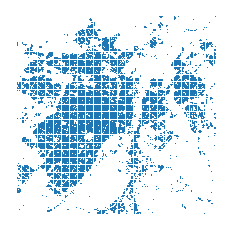

(1130973.1041649997, 1133324.812535, 754951.6677, 757288.2063000001)

In [0]:
rej_pred_XG.plot()
plt.axis('off')